In [ ]:
import os
import shutil
import random

# Define input and output paths
pose_frame_root = "Pose_Frames"  # Source dataset
output_root = "dataset"  # Destination dataset
train_ratio = 0.66  # 66% for training, 34% for validation

# Create train and validation directories
train_dir = os.path.join(output_root, "train")
val_dir = os.path.join(output_root, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Process each activity category
for category in os.listdir(pose_frame_root):
    category_path = os.path.join(pose_frame_root, category)
    if os.path.isdir(category_path):
        
        # Get all video folders inside the category
        video_folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]
        
        # Shuffle and split video folders into train and validation sets
        random.shuffle(video_folders)
        split_idx = int(len(video_folders) * train_ratio)
        train_videos = video_folders[:split_idx]
        val_videos = video_folders[split_idx:]

        # Create category folders inside train and val directories
        train_category_path = os.path.join(train_dir, category)
        val_category_path = os.path.join(val_dir, category)
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(val_category_path, exist_ok=True)

        # Move video folders into train and val directories
        for video_folder in train_videos:
            src_path = os.path.join(category_path, video_folder)
            dest_path = os.path.join(train_category_path, video_folder)
            shutil.copytree(src_path, dest_path)
        
        for video_folder in val_videos:
            src_path = os.path.join(category_path, video_folder)
            dest_path = os.path.join(val_category_path, video_folder)
            shutil.copytree(src_path, dest_path)

print("✅ Dataset organized successfully with train/val split at the video folder level!")


In [2]:
import tensorflow as tf
import os

# Define dataset paths
dataset_root = "dataset"
train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")

# Image settings
img_size = (224, 224)  # Resize images to 224x224
batch_size = 32  # Batch size for training
AUTOTUNE = tf.data.AUTOTUNE  # Optimize loading performance

# ⚡ Data Augmentation for better generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  
    tf.keras.layers.RandomRotation(0.2),  
    tf.keras.layers.RandomZoom(0.2),  
    tf.keras.layers.RandomContrast(0.2),
])

# ⚡ Load datasets with class names auto-detected
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Get class names
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"📊 Total Classes Detected: {num_classes} ➝ {class_names}")

# Normalize images (Rescale pixel values from [0, 255] to [0, 1])
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation (only to training data)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# ⚡ Improve Performance: Caching and Prefetching
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# ⚡ Check dataset output shape
for images, labels in train_dataset.take(1):
    print(f"✅ Sample batch shape: {images.shape}, Labels shape: {labels.shape}")

print("🚀 Data loaded, preprocessed, and optimized successfully!")


Found 1793 files belonging to 13 classes.
Found 928 files belonging to 13 classes.
📊 Total Classes Detected: 13 ➝ ['fall', 'grab', 'gun', 'hit', 'kick', 'lying_down', 'run', 'sit', 'sneak', 'stand', 'struggle', 'throw', 'walk']
✅ Sample batch shape: (32, 224, 224, 3), Labels shape: (32,)
🚀 Data loaded, preprocessed, and optimized successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
import os

# ✅ Define Image Size & Batch Size
IMG_SIZE = (224, 224)  # Recommended for MobileNetV2
BATCH_SIZE = 16
EPOCHS = 25
NUM_CLASSES = 13  # Change according to your dataset

# ✅ Define Paths
train_dir = "dataset/train"
val_dir = "dataset/val"

# ✅ Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)
val_dataset = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

# ✅ Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze most layers
    layer.trainable = False

# ✅ Build Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-4)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

# ✅ Learning Rate Scheduler & Optimizer
lr_schedule = ExponentialDecay(
    initial_learning_rate=5e-5, decay_steps=1000, decay_rate=0.95, staircase=True
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

# ✅ Compile Model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# ✅ Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# ✅ Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# ✅ Save Model
model.save("cctv_anomaly_detection_mobilenetv2.keras")


Found 1793 images belonging to 13 classes.
Found 928 images belonging to 13 classes.
Epoch 1/25
113/113 [==============================] - 89s 740ms/step - loss: 2.8444 - accuracy: 0.1110 - val_loss: 2.6701 - val_accuracy: 0.1239 - lr: 5.0000e-05
Epoch 2/25
113/113 [==============================] - 209s 2s/step - loss: 2.5503 - accuracy: 0.1885 - val_loss: 2.6680 - val_accuracy: 0.1315 - lr: 5.0000e-05
Epoch 3/25
113/113 [==============================] - 126s 1s/step - loss: 2.4193 - accuracy: 0.2370 - val_loss: 2.6798 - val_accuracy: 0.1519 - lr: 5.0000e-05
Epoch 4/25
113/113 [==============================] - 80s 700ms/step - loss: 2.3471 - accuracy: 0.2677 - val_loss: 2.6872 - val_accuracy: 0.1466 - lr: 5.0000e-05
Epoch 5/25
113/113 [==============================] - ETA: 0s - loss: 2.2328 - accuracy: 0.3196
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
113/113 [==============================] - 75s 667ms/step - loss: 2.2328 - accuracy: 0.3196 - val_l

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.1344 - loss: 3.8310 - val_accuracy: 0.0356 - val_loss: 3.1177
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.1490 - loss: 2.5922 - val_accuracy: 0.0700 - val_loss: 2.6577
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.1622 - loss: 2.4690 - val_accuracy: 0.1110 - val_loss: 6.5897
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2074 - loss: 2.3759 - val_accuracy: 0.0970 - val_loss: 3.0533
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2239 - loss: 2.3421 - val_accuracy: 0.1153 - val_loss: 3.4077


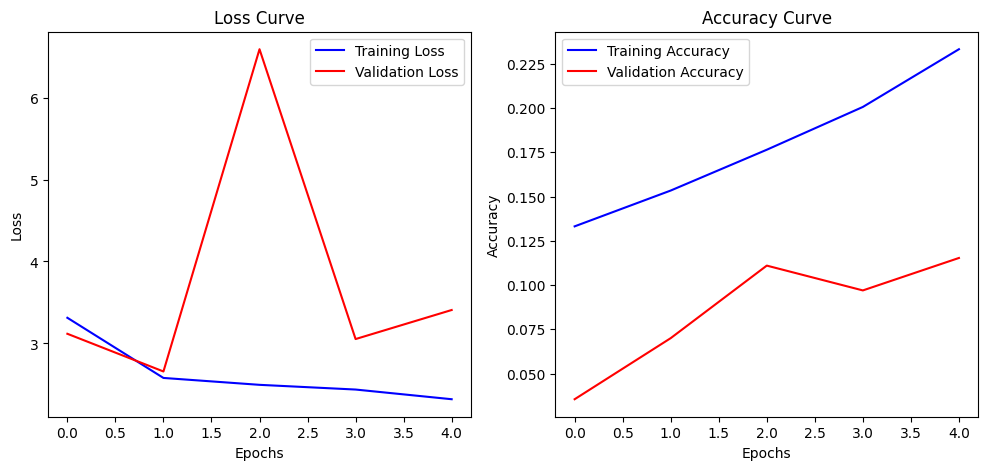

✅ Model saved at: saved_model/cctv_anomaly_model.h5
